In [3]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/ok/2517754059478547988.jpg  
  inflating: data/ok/-8896413441695728204.jpg  
  inflating: data/ok/-4038019199864736990_90.jpg  
  inflating: data/ok/3395102819547706846_180.jpg  
  inflating: data/ok/6435535882199308555_270.jpg  
  inflating: data/ok/1857397537820341460_180.jpg  
  inflating: data/ok/7088880965531492320.jpg  
  inflating: data/ok/3972380226290087302_180.jpg  
  inflating: data/ok/7913608948582337967_90.jpg  
  inflating: data/ok/-394917516562167653_270.jpg  
  inflating: data/ok/-7968535116429408034_180.jpg  
  inflating: data/ok/-3170505566557376314_180.jpg  
  inflating: data/ok/-3740495164911687941.jpg  
  inflating: data/ok/-2934383283674695245.jpg  
  inflating: data/ok/1565963575110519410_180.jpg  
  inflating: data/ok/-6196041164866944428_90.jpg  
  inflating: data/ok/5732773055361840100_90.jpg  
  inflating: data/ok/-6098190147036247365_270.jpg  
  inflating: data/ok/-8890661928743610539_180.j

In [17]:
import torch
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])
data = datasets.ImageFolder('data', transform=transform)

In [18]:
train_set, val_set = torch.utils.data.random_split(data, [0.9, 0.1])
train_data = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_data = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

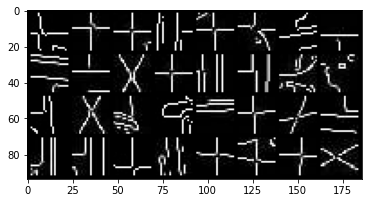

1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 1


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_data)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(32)))

In [8]:
len(val_set)

966

In [9]:
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(1,16,3),
        nn.ReLU(),
        nn.LazyBatchNorm2d(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(16,64,3),
        nn.ReLU(),
        nn.LazyBatchNorm2d(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Flatten(),
        nn.Dropout(0.4),
        nn.LazyLinear(64),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.LazyLinear(1),
    )
  
  def forward(self, X):
    return self.model(X)
  
model = CNN().to(device)


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [52]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.LazyLinear(1)
model = model.to(device)

In [53]:
!pip install torchmetrics
from torchmetrics import Accuracy

accuracy_fn = Accuracy(task='binary').to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0001)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
from tqdm.auto import tqdm

epochs = 10
for epoch in range(epochs):
  train_loss = 0.0
  train_acc = 0.0
  model.train()
  for i, (X, y) in enumerate(tqdm(train_data)):
    X = X.to(device)
    y = y.to(device)
    logits = model(X)
    loss = criterion(logits, y.unsqueeze(1).float())
    train_loss += loss
    y_probs = torch.sigmoid(logits)
    y_preds = torch.tensor([1 if prob > 0.5 else 0 for prob in y_probs]).to(device)
    train_acc += accuracy_fn(y, y_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_data)
  train_acc /= len(train_data)
  
  test_loss = 0.0
  test_acc = 0.0
  model.eval()
  with torch.inference_mode():
    for i, (X, y) in enumerate(val_data):
      X = X.to(device)
      y = y.to(device)
      logits = model(X)
      loss = criterion(logits, y.unsqueeze(1).float())
      test_loss += loss
      y_probs = torch.sigmoid(logits)
      y_preds = torch.tensor([1 if prob > 0.5 else 0 for prob in y_probs]).to(device)
      test_acc += accuracy_fn(y, y_preds)
    test_loss /= len(val_data)
    test_acc /= len(val_data)
  print(f'{epoch + 1} Train loss: {train_loss:.3f} , Train accuracy {train_acc:.3f} | Validation loss: {test_loss:.3f} , Validation accuracy {test_acc:.3f}')
  

  0%|          | 0/272 [00:00<?, ?it/s]

1 Train loss: 0.209 , Train accuracy 0.934 | Validation loss: 0.098 , Validation accuracy 0.968


  0%|          | 0/272 [00:00<?, ?it/s]

2 Train loss: 0.061 , Train accuracy 0.977 | Validation loss: 0.093 , Validation accuracy 0.968


  0%|          | 0/272 [00:00<?, ?it/s]

3 Train loss: 0.042 , Train accuracy 0.986 | Validation loss: 0.053 , Validation accuracy 0.985


  0%|          | 0/272 [00:00<?, ?it/s]

4 Train loss: 0.029 , Train accuracy 0.990 | Validation loss: 0.063 , Validation accuracy 0.982


  0%|          | 0/272 [00:00<?, ?it/s]

5 Train loss: 0.022 , Train accuracy 0.993 | Validation loss: 0.056 , Validation accuracy 0.984


  0%|          | 0/272 [00:00<?, ?it/s]

6 Train loss: 0.022 , Train accuracy 0.993 | Validation loss: 0.057 , Validation accuracy 0.985


  0%|          | 0/272 [00:00<?, ?it/s]

7 Train loss: 0.018 , Train accuracy 0.994 | Validation loss: 0.046 , Validation accuracy 0.985


  0%|          | 0/272 [00:00<?, ?it/s]

8 Train loss: 0.014 , Train accuracy 0.996 | Validation loss: 0.099 , Validation accuracy 0.972


  0%|          | 0/272 [00:00<?, ?it/s]

9 Train loss: 0.017 , Train accuracy 0.994 | Validation loss: 0.044 , Validation accuracy 0.982


  0%|          | 0/272 [00:00<?, ?it/s]

10 Train loss: 0.010 , Train accuracy 0.997 | Validation loss: 0.052 , Validation accuracy 0.984


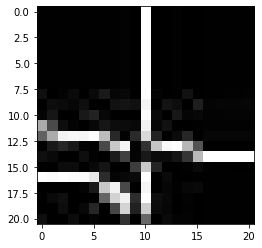

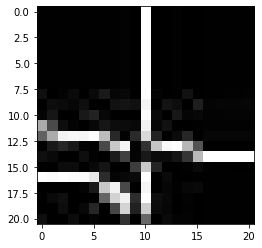

tensor(1, device='cuda:0')


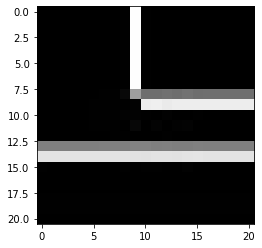

tensor(0, device='cuda:0')


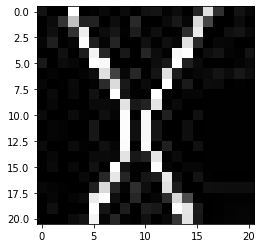

tensor(1, device='cuda:0')


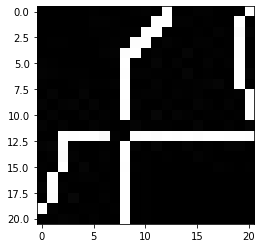

tensor(1, device='cuda:0')


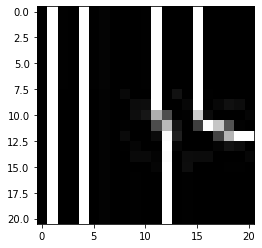

tensor(0, device='cuda:0')


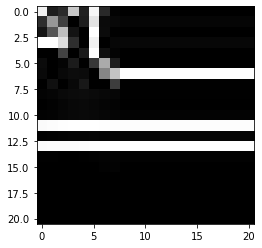

tensor(0, device='cuda:0')


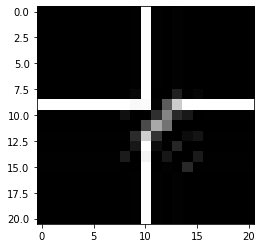

tensor(1, device='cuda:0')


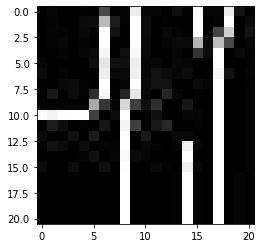

tensor(0, device='cuda:0')


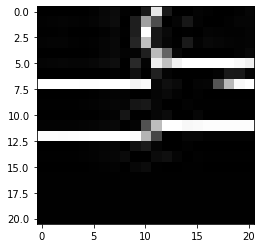

tensor(0, device='cuda:0')


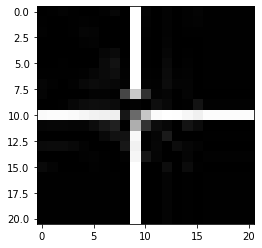

tensor(1, device='cuda:0')


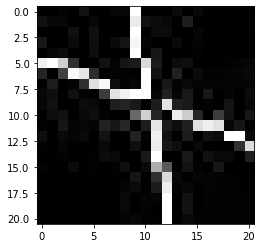

tensor(1, device='cuda:0')


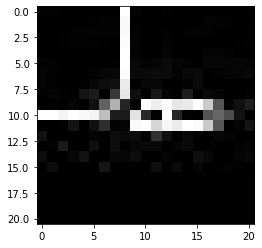

tensor(0, device='cuda:0')


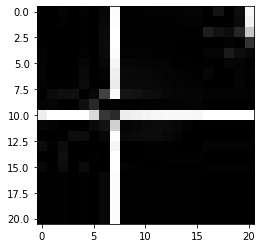

tensor(1, device='cuda:0')


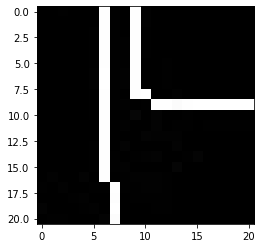

tensor(0, device='cuda:0')


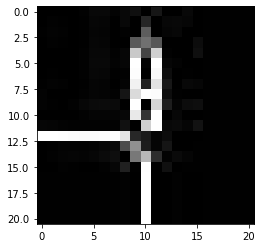

tensor(0, device='cuda:0')


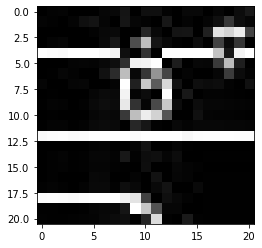

tensor(0, device='cuda:0')


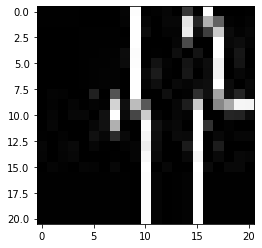

tensor(0, device='cuda:0')


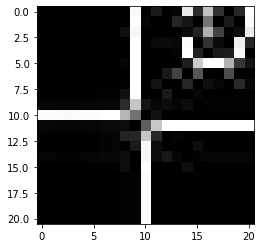

tensor(1, device='cuda:0')


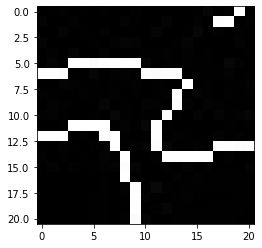

tensor(0, device='cuda:0')


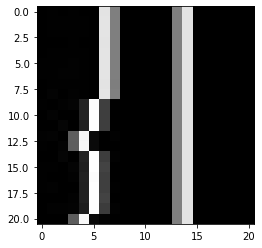

tensor(0, device='cuda:0')


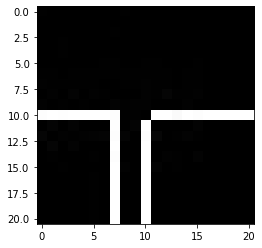

tensor(0, device='cuda:0')


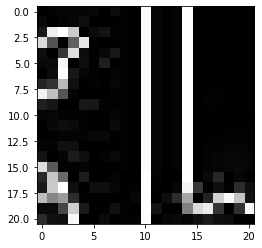

tensor(0, device='cuda:0')


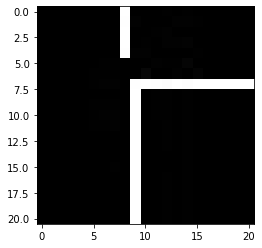

tensor(0, device='cuda:0')


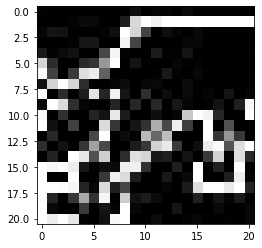

tensor(0, device='cuda:0')


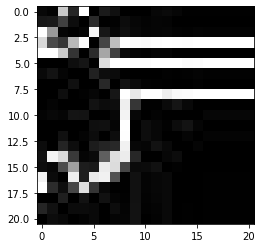

tensor(0, device='cuda:0')


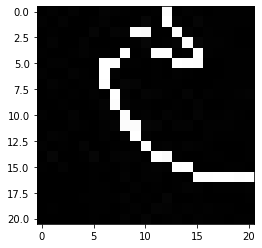

tensor(0, device='cuda:0')


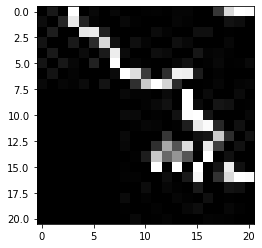

tensor(0, device='cuda:0')


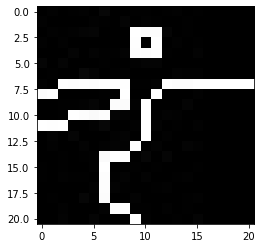

tensor(0, device='cuda:0')


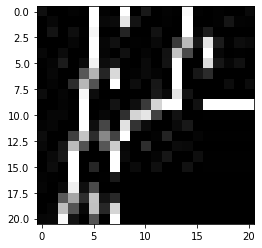

tensor(0, device='cuda:0')


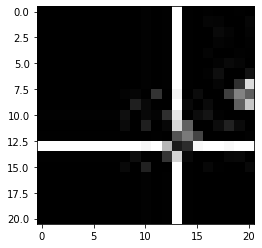

tensor(1, device='cuda:0')


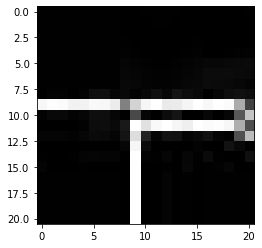

tensor(0, device='cuda:0')


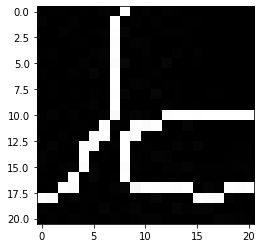

tensor(0, device='cuda:0')


In [55]:
images, labels = next(iter(val_data))
images, labels = images.to(device), labels.to(device)
imshow(images[0].cpu())

for i in range(len(images)):
  imshow(images[i].cpu())
  print(labels[i])


In [56]:
outputs = model(images)
preds = [1 if prob > 0.5 else 0 for prob in torch.sigmoid(outputs)]

for i in range(len(preds)):
  if(preds[i] != labels[i].item()):
    imshow(images[i].cpu())
    print(labels[i], preds[i])

In [58]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "resnet18.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model, f=MODEL_SAVE_PATH)